In [1]:
# TODO: Document the code and refactor it.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, SeparableConv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model

In [2]:
def upconv_concat(bottom_a, bottom_b, n_filter, pool_size, stride, padding='VALID'):
    up_conv = Conv2DTranspose(filters=n_filter, kernel_size=[pool_size, pool_size],
                                         strides=stride, padding=padding)(bottom_a)
    return Concatenate(axis=-1)([up_conv, bottom_b])


In [3]:
#Pre-process images
import os
import cv2
import matplotlib.pyplot as plt

train_images = os.listdir('../input/wnetdataset/data/Data/train')
val_images = os.listdir('../input/wnetdataset/data/Data/val')

X_train = []
X_val = []

for i in range(len(train_images)):
    img = cv2.imread('../input/wnetdataset/data/Data/train/'+train_images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
    X_train.append(resized)
X_train = np.asarray(X_train)
X_train = X_train.astype('float32')/255.
X_train = np.reshape(X_train, (len(X_train), 224, 224, 1))

for i in range(len(val_images)):
    img = cv2.imread('../input/wnetdataset/data/Data/val/'+val_images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
    X_val.append(resized)
X_val = np.asarray(X_val)
X_val = X_val.astype('float32')/255.
X_val = np.reshape(X_val, (len(X_val), 224, 224, 1))

print(len(X_train))
print(len(X_val))


360
100


In [4]:
class Custom_Conv(tf.keras.layers.Layer):
    def __init__(self, *args, **kargs):
        super(Custom_Conv, self).__init__()
    def call(self, bottom, k_size, num_outputs, stride):
        input_channels = int(bottom.get_shape()[-1])

        # initialize weights and biases using xavier
        weights = tf.truncated_normal(shape=[k_size, k_size, input_channels, num_outputs], dtype=tf.float32,
                                                  stddev=np.sqrt(1.0 / (k_size * k_size * input_channels)))

        biases = tf.constant(0, dtype=tf.float32, shape=[num_outputs])
        
        # conv = convolve(bottom, weights)
        conv = tf.nn.conv2d(bottom, weights, strides=[1, stride, stride, 1], padding='SAME')

        # Add biases
        bias = tf.reshape(tf.nn.bias_add(conv, biases), tf.shape(conv))

        # Apply relu function
        softmax = tf.nn.softmax(bias)
        return softmax


In [5]:
class Custom_Conv2(tf.keras.layers.Layer):
    def __init__(self, *args, **kargs):
        super(Custom_Conv2, self).__init__()
    def call(self, bottom, k_size, num_outputs, stride):
        input_channels = int(bottom.get_shape()[-1])

        # initialize weights and biases using xavier
        weights = tf.Variable(tf.truncated_normal(shape=[k_size, k_size, input_channels, num_outputs], dtype=tf.float32,
                                                  stddev=np.sqrt(1.0 / (k_size * k_size * input_channels))))

        biases = tf.Variable(tf.constant(0, dtype=tf.float32, shape=[num_outputs]))
        
        # conv = convolve(bottom, weights)
        conv = tf.nn.conv2d(bottom, weights, strides=[1, stride, stride, 1], padding='SAME')

        # Add biases
        bias = tf.reshape(tf.nn.bias_add(conv, biases), tf.shape(conv))

        # Apply relu function
        relu = tf.nn.relu(bias)
        return relu


In [6]:
input_img = Input(shape=(224, 224, 1))
droprate=0.25
num_classes = 3 #background, cell boundary, cell.

In [7]:
#Encoder

#Module 1
conv_1_1 = Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(input_img)
conv_1_1_bn = BatchNormalization()(conv_1_1)
conv_1_1_do = Dropout(droprate)(conv_1_1_bn)

conv_1_2 = Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(conv_1_1_do)
conv_1_2_bn = BatchNormalization()(conv_1_2)
conv_1_2_do = Dropout(droprate)(conv_1_2_bn)

pool_1 = MaxPooling2D(pool_size= 2, strides = 2)(conv_1_2_do) #Module 1 to Module 2

#Module 2

conv_2_1 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(pool_1)
conv_2_1_bn = BatchNormalization()(conv_2_1)
conv_2_1_do = Dropout(droprate)(conv_2_1_bn)

conv_2_2 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(conv_2_1_do)
conv_2_2_bn = BatchNormalization()(conv_2_2)
conv_2_2_do = Dropout(droprate)(conv_2_2_bn)

pool_2 = MaxPooling2D(pool_size= 2, strides = 2)(conv_2_2_do) #Module 2 to Module 3

#Module 3

conv_3_1 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(pool_2)
conv_3_1_bn = BatchNormalization()(conv_3_1)
conv_3_1_do = Dropout(droprate)(conv_3_1_bn)

conv_3_2 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(conv_3_1_do)
conv_3_2_bn = BatchNormalization()(conv_3_2)
conv_3_2_do = Dropout(droprate)(conv_3_2_bn)

pool_3 = MaxPooling2D(pool_size= 2, strides = 2)(conv_3_2_do) #Module 3 to Module 4

#Module 4

conv_4_1 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(pool_3)
conv_4_1_bn = BatchNormalization()(conv_4_1)
conv_4_1_do = Dropout(droprate)(conv_4_1_bn)

conv_4_2 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(conv_4_1_do)
conv_4_2_bn = BatchNormalization()(conv_4_2)
conv_4_2_do = Dropout(droprate)(conv_4_2_bn)

pool_4 = MaxPooling2D(pool_size= 2, strides = 2)(conv_4_2_do) #Module 4 to Module 5

#Module 5

conv_5_1 = SeparableConv2D(filters = 1024, kernel_size = 3, activation='relu', padding='same')(pool_4)
conv_5_1_bn = BatchNormalization()(conv_5_1)
conv_5_1_do = Dropout(droprate)(conv_5_1_bn)

conv_5_2 = SeparableConv2D(filters = 1024, kernel_size = 3, activation='relu', padding='same')(conv_5_1_do)
conv_5_2_bn = BatchNormalization()(conv_5_2)
conv_5_2_do = Dropout(droprate)(conv_5_2_bn)

upconv_1 = upconv_concat(conv_5_2_do, conv_4_2_do, n_filter=512, pool_size=2, stride=2) #Module 5 to 6

#Module 6

conv_6_1 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(upconv_1)
conv_6_1_bn = BatchNormalization()(conv_6_1)
conv_6_1_do = Dropout(droprate)(conv_6_1_bn)

conv_6_2 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(conv_6_1_do)
conv_6_2_bn = BatchNormalization()(conv_6_2)
conv_6_2_do = Dropout(droprate)(conv_6_2_bn)

upconv_2 = upconv_concat(conv_6_2_do, conv_3_2_do, n_filter=256, pool_size=2, stride=2) #Module 6 to 7

#Module 7

conv_7_1 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(upconv_2)
conv_7_1_bn = BatchNormalization()(conv_7_1)
conv_7_1_do = Dropout(droprate)(conv_7_1_bn)

conv_7_2 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(conv_7_1_do)
conv_7_2_bn = BatchNormalization()(conv_7_2)
conv_7_2_do = Dropout(droprate)(conv_7_2_bn)

upconv_3 = upconv_concat(conv_7_2_do, conv_2_2_do, n_filter=128, pool_size=2, stride=2) #Module 7 to 8

#Module 8

conv_8_1 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(upconv_3)
conv_8_1_bn = BatchNormalization()(conv_8_1)
conv_8_1_do = Dropout(droprate)(conv_8_1_bn)

conv_8_2 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(conv_8_1_do)
conv_8_2_bn = BatchNormalization()(conv_8_2)
conv_8_2_do = Dropout(droprate)(conv_8_2_bn)

upconv_4 = upconv_concat(conv_8_2_do, conv_1_2_do, n_filter=64, pool_size=2, stride=2) #Module 8 to 9

#Module 9

conv_9_1 = SeparableConv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(upconv_4)
conv_9_1_bn = BatchNormalization()(conv_9_1)
conv_9_1_do = Dropout(droprate)(conv_9_1_bn)

conv_9_2 = SeparableConv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(conv_9_1_do)
conv_9_2_bn = BatchNormalization()(conv_9_2)
conv_9_2_do = Dropout(droprate)(conv_9_2_bn)

encoder_output = Custom_Conv2()(conv_9_2_do, k_size=1, num_outputs=3, stride=1) #Module 9 to 10

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
#Decoder

#Module 10

conv_10_1 = Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(encoder_output)
conv_10_1_bn = BatchNormalization()(conv_10_1)
conv_10_1_do = Dropout(droprate)(conv_10_1_bn)

conv_10_2 = Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(conv_10_1_do)
conv_10_2_bn = BatchNormalization()(conv_10_2)
conv_10_2_do = Dropout(droprate)(conv_10_2_bn)

pool_5 = MaxPooling2D(pool_size= 2, strides = 2)(conv_10_2_do) #Module 10 to 11

#Module 11

conv_11_1 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(pool_5)
conv_11_1_bn = BatchNormalization()(conv_11_1)
conv_11_1_do = Dropout(droprate)(conv_11_1_bn)

conv_11_2 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(conv_11_1_do)
conv_11_2_bn = BatchNormalization()(conv_11_2)
conv_11_2_do = Dropout(droprate)(conv_11_2_bn)

pool_6 = MaxPooling2D(pool_size= 2, strides = 2)(conv_11_2_do) #Module 11 to 12

#Module 12

conv_12_1 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(pool_6)
conv_12_1_bn = BatchNormalization()(conv_12_1)
conv_12_1_do = Dropout(droprate)(conv_12_1_bn)

conv_12_2 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(conv_12_1_do)
conv_12_2_bn = BatchNormalization()(conv_12_2)
conv_12_2_do = Dropout(droprate)(conv_12_2_bn)

pool_7 = MaxPooling2D(pool_size= 2, strides = 2)(conv_12_2_do) #Module 12 to 13

#Module 13

conv_13_1 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(pool_7)
conv_13_1_bn = BatchNormalization()(conv_13_1)
conv_13_1_do = Dropout(droprate)(conv_13_1_bn)

conv_13_2 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(conv_13_1_do)
conv_13_2_bn = BatchNormalization()(conv_13_2)
conv_13_2_do = Dropout(droprate)(conv_13_2_bn)

pool_8 = MaxPooling2D(pool_size= 2, strides = 2)(conv_13_2_do) #Module 13 to 14

#Module 14

conv_14_1 = SeparableConv2D(filters = 1024, kernel_size = 3, activation='relu', padding='same')(pool_8)
conv_14_1_bn = BatchNormalization()(conv_14_1)
conv_14_1_do = Dropout(droprate)(conv_14_1_bn)

conv_14_2 = SeparableConv2D(filters = 1024, kernel_size = 3, activation='relu', padding='same')(conv_14_1_do)
conv_14_2_bn = BatchNormalization()(conv_14_2)
conv_14_2_do = Dropout(droprate)(conv_14_2_bn)

upconv_5 = upconv_concat(conv_14_2_do, conv_13_2_do, n_filter=512, pool_size=2, stride=2)  #Module 14 to 15

#Module 15

conv_15_1 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(upconv_5)
conv_15_1_bn = BatchNormalization()(conv_15_1)
conv_15_1_do = Dropout(droprate)(conv_15_1_bn)

conv_15_2 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(conv_15_1_do)
conv_15_2_bn = BatchNormalization()(conv_15_2)
conv_15_2_do = Dropout(droprate)(conv_15_2_bn)

upconv_6 = upconv_concat(conv_15_2_do, conv_12_2_do, n_filter=256, pool_size=2, stride=2)  #Module 15 to 16

#Module 16

conv_16_1 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(upconv_6)
conv_16_1_bn = BatchNormalization()(conv_16_1)
conv_16_1_do = Dropout(droprate)(conv_16_1_bn)

conv_16_2 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(conv_16_1_do)
conv_16_2_bn = BatchNormalization()(conv_16_2)
conv_16_2_do = Dropout(droprate)(conv_16_2_bn)

upconv_7 = upconv_concat(conv_16_2_do, conv_11_2_do, n_filter=128, pool_size=2, stride=2)  #Module 16 to 17

#Module 17

conv_17_1 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(upconv_7)
conv_17_1_bn = BatchNormalization()(conv_17_1)
conv_17_1_do = Dropout(droprate)(conv_17_1_bn)

conv_17_2 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(conv_17_1_do)
conv_17_2_bn = BatchNormalization()(conv_17_2)
conv_17_2_do = Dropout(droprate)(conv_17_2_bn)

upconv_8 = upconv_concat(conv_17_2_do, conv_10_2_do, n_filter=64, pool_size=2, stride=2)  #Module 17 to 18

#Module 18

conv_18_1 = Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(upconv_8)
conv_18_1_bn = BatchNormalization()(conv_18_1)
conv_18_1_do = Dropout(droprate)(conv_18_1_bn)

conv_18_2 = Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(conv_18_1_do)
conv_18_2_bn = BatchNormalization()(conv_18_2)
conv_18_2_do = Dropout(droprate)(conv_18_2_bn)

decoder_output = Custom_Conv2()(conv_18_2_do, k_size=1, num_outputs=1, stride=1)

In [9]:
init1 = tf.global_variables_initializer()
init2 = tf.local_variables_initializer()

In [10]:
wnet_autoencoder = Model(input_img, decoder_output)

In [11]:
wnet_autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 224, 224, 64) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [12]:
encoder_model = Model(input_img, encoder_output)

In [13]:
with tf.Session() as sess:
    sess.run(init1)
    sess.run(init2)
    encoder_model.compile(optimizer='adagrad', loss='mean_squared_error')
    history = encoder_model.fit(X_train, X_train,
                    epochs=5,
                    batch_size=8,
                    shuffle=True,
                    validation_data=(X_val, X_val)).history

Instructions for updating:
Use tf.cast instead.
Train on 360 samples, validate on 100 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
360/360 [==============================] - 24s 65ms/sample - loss: 0.0693 - val_loss: 0.0457
Epoch 2/5
360/360 [==============================] - 18s 50ms/sample - loss: 0.0194 - val_loss: 0.0457
Epoch 3/5
360/360 [==============================] - 18s 50ms/sample - loss: 0.0129 - val_loss: 0.0457
Epoch 4/5
360/360 [==============================] - 18s 50ms/sample - loss: 0.0086 - val_loss: 0.0457
Epoch 5/5
360/360 [==============================] - 18s 50ms/sample - loss: 0.0058 - val_loss: 0.0457


In [ ]:
with tf.Session() as sess:
    sess.run(init1)
    sess.run(init2)
    wnet_autoencoder.compile(optimizer='adagrad', loss='mean_squared_error')
    history = wnet_autoencoder.fit(X_train, X_train,
                    epochs=5,
                    batch_size=8,
                    shuffle=True,
                    validation_data=(X_val, X_val)).history

In [ ]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [14]:
img = cv2.imread('../input/test-dataset/a184.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
resized = resized/255
resized1 = resized[:, :, np.newaxis]
print(resized1.shape)
resized1 = resized1[np.newaxis, :, :] 
print(resized1.shape)

(224, 224, 1)
(1, 224, 224, 1)


In [ ]:
with tf.Session() as sess:
    sess.run(init1)
    sess.run(init2)
    img2 = wnet_autoencoder.predict(resized1)
    img2 = img2.reshape((224,224))
    #img2[223]

In [ ]:
plt.imshow(img2)

In [35]:
with tf.Session() as sess:
    sess.run(init1)
    sess.run(init2)
    img3 = encoder_model.predict(resized1)
img3.shape

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fbea9c54d68>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


(1, 224, 224, 3)

In [36]:
img3 = img3*255
img3

array([[[[6.96084317e-16, 0.00000000e+00, 0.00000000e+00],
         [1.24468673e-16, 5.00255329e-16, 1.11415125e-15],
         [0.00000000e+00, 3.97899074e-16, 2.84305889e-15],
         ...,
         [0.00000000e+00, 6.93620272e-09, 2.83342438e-09],
         [7.40184003e-09, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 3.22935523e-09, 0.00000000e+00]],

        [[8.10460645e-18, 0.00000000e+00, 0.00000000e+00],
         [8.30825607e-16, 1.31608147e-15, 0.00000000e+00],
         [5.91984392e-16, 1.36220442e-15, 1.33744851e-15],
         ...,
         [2.09492494e-08, 0.00000000e+00, 0.00000000e+00],
         [8.97426933e-09, 0.00000000e+00, 0.00000000e+00],
         [7.30245331e-09, 0.00000000e+00, 0.00000000e+00]],

        [[2.73865842e-16, 1.23498812e-15, 0.00000000e+00],
         [0.00000000e+00, 1.57467395e-15, 0.00000000e+00],
         [0.00000000e+00, 2.01532347e-15, 2.28197108e-16],
         ...,
         [0.00000000e+00, 1.83093736e-08, 7.88597632e-09],
         [

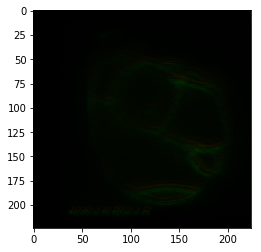

In [37]:
plt.imshow(img3.reshape(224,224,3))